In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import ExpSineSquared, WhiteKernel, ConstantKernel, RBF, DotProduct, RationalQuadratic

In [17]:
data = pd.read_csv("co2_daily_mlo.csv")
data["Date"] = pd.to_datetime(dict(
    year=data["Year"],
    month=data["Month"],
    day=data["Day"]
))
data = data.set_index("Date")
smoothed_data = data.resample("1ME").mean(numeric_only=True).dropna().reset_index()
smoothed_data.set_index("Date")
features = smoothed_data[["Exact"]]
labels = smoothed_data[["C02"]]

In [18]:
linear_model = TransformedTargetRegressor(
    regressor=Pipeline(steps=[
        ("regressor", LinearRegression())
    ]),
    transformer=StandardScaler()
)

kernel = 50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)
gpp_model = Pipeline(steps=[
    ("regressor", GaussianProcessRegressor(normalize_y=False, kernel=kernel))
])

In [19]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, shuffle=False)

In [20]:
linear_model.fit(x_train, y_train)

TransformedTargetRegressor(regressor=Pipeline(steps=[('regressor',
                                                      LinearRegression())]),
                           transformer=StandardScaler())

In [21]:
gpp_model.fit(x_train, y_train)

/usr/local/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Pipeline(steps=[('regressor',
                 GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)))])

In [60]:
def create_days_of_year(years=1):
    dates = pd.DataFrame(pd.date_range(start='2026-01-01', periods=years*365, freq='D'), columns=["Date"])
    dates["Day"] = dates["Date"].dt.day
    dates["Month"] = dates["Date"].dt.month
    dates["Year"] = dates["Date"].dt.year
    dates["Exact"] = dates["Day"] / 31 + dates["Month"] / 12 + dates["Year"]
    return dates[["Exact"]]

In [22]:
def create_full_table(features, labels, predictions, stds=None):
    features = features.copy()
    features["C02"] = labels
    features["C02^"] = predictions
    if stds is not None:
        features["Std"] = stds
    return features.sort_values("Exact")

In [73]:
features_combined = pd.concat([x_train, x_test, create_days_of_year(25)], axis=0, ignore_index=False)
labels_combined = pd.concat([y_train, y_test], axis=0, ignore_index=False)

linear_predictions = linear_model.predict(features_combined)
gpp_means, gpp_stds = gpp_model.predict(features_combined, return_std=True)

linear_table = create_full_table(features_combined, labels_combined, linear_predictions)
gpp_table = create_full_table(features_combined, labels_combined, gpp_means, gpp_stds)

In [74]:
%matplotlib widget

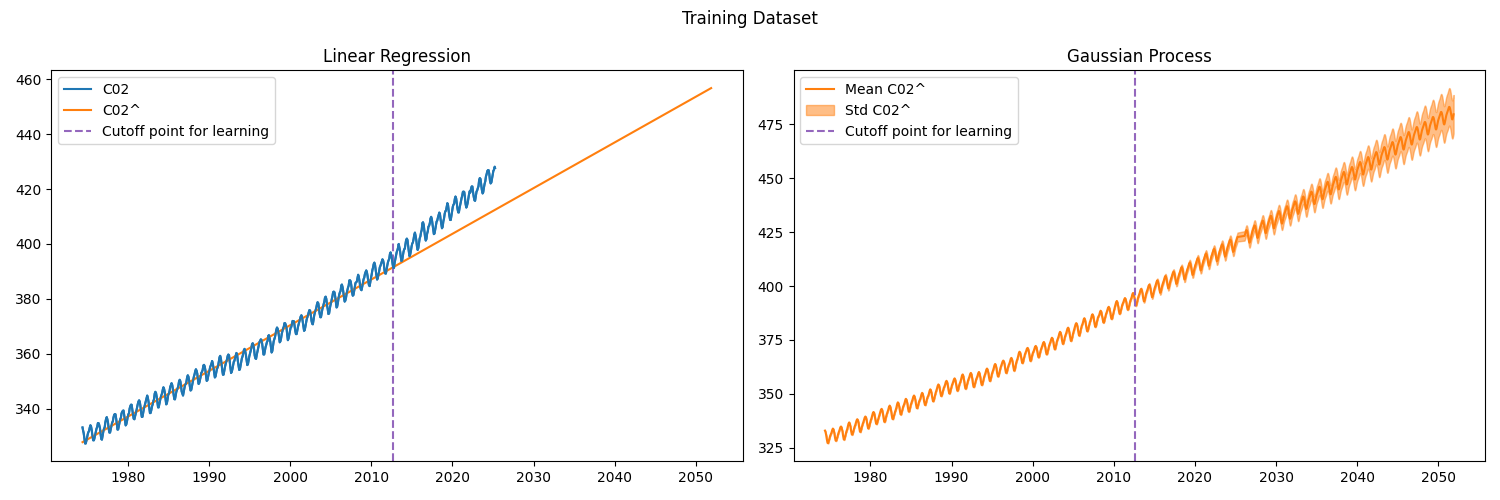

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=False, sharey=False)

ax[0].set_title("Linear Regression")
ax[0].plot(linear_table["Exact"].iloc[:len(labels_combined)], linear_table["C02"].iloc[:len(labels_combined)], c="tab:blue", label="C02")
ax[0].plot(linear_table["Exact"], linear_table["C02^"], c="tab:orange", label="C02^")
ax[0].axvline(x=x_test["Exact"].iloc[0], color='tab:purple', linestyle='--', label="Cutoff point for learning")
ax[0].legend()

ax[1].set_title("Gaussian Process")
ax[0].plot(gpp_table["Exact"].iloc[:len(labels_combined)], gpp_table["C02"].iloc[:len(labels_combined)], c="tab:blue", label="C02")
ax[1].plot(gpp_table["Exact"], gpp_table["C02^"], c="tab:orange", label="Mean C02^")
ax[1].fill_between(gpp_table["Exact"], gpp_table["C02^"] - gpp_table["Std"], gpp_table["C02^"] + gpp_table["Std"], label="Std C02^", color="tab:orange", alpha=.5)
ax[1].axvline(x=x_test["Exact"].iloc[0], color='tab:purple', linestyle='--', label="Cutoff point for learning")
ax[1].legend()

fig.suptitle("Training Dataset")
fig.tight_layout()